# PageRank

## Using the `networkx` library

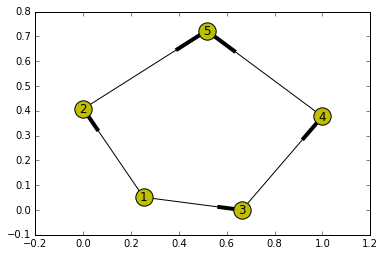

Node 3's out degree = 1 	Node 3's degree = 2
Node 1's successors = [2, 3] 	Node 1's neighbors = [2, 3]
Node 4's neighbors = [5]
Shortest path from Node 1 to 4 [1, 3, 4]
Error: No Path Between Them!


In [4]:
import matplotlib.pyplot as plt
import networkx as nx
# c.f., https://networkx.readthedocs.org/en/stable/tutorial/tutorial.html#directed-graphs

%matplotlib inline
# disable future warning
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

# construct a directed graph
# 1 --> 2 ---------\
#   \-> 3 --> 4 --> 5
G = nx.DiGraph(name="test")
edges = [(1, 2), (1, 3), (2, 5), (3, 4), (4, 5)]
for edge in edges:
    G.add_edge(*edge)

# for better drawing, use `graphviz`, as drawing errors and controlling layout 
# using matplotlib is tricky to say the least.  
nx.draw_networkx(G, with_labels=True, node_color='y')
plt.show()
    
print("Node 3's out degree =", G.out_degree(3), "\tNode 3's degree =", G.degree(3))
print("Node 1's successors =", G.successors(1), "\tNode 1's neighbors =", G.neighbors(1))
print("Node 4's neighbors =", G.neighbors(4))

try:
    sp = nx.shortest_path(G, 1, 4)
    print("Shortest path from Node 1 to 4", sp)
    
    sp = nx.shortest_path(G, 4, 1)
    print("Shortest path from Node 4 to 1", sp)
except nx.NetworkXNoPath:
    print("Error: No Path Between Them!")

## PageRank 

Node 1's successors = ['microsoft', 'yahoo', 'amazon'] 	Node Yahoo's neighbors = ['microsoft', 'yahoo', 'amazon']
Yahoo's edges: [('yahoo', 'microsoft', {'weight': 0}), ('yahoo', 'yahoo', {'weight': 0.5}), ('yahoo', 'amazon', {'weight': 0.5})]


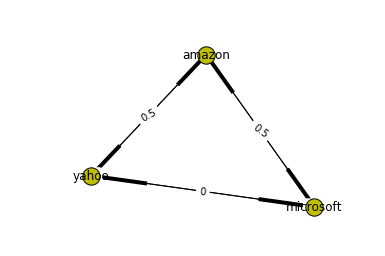

In [5]:
sites = ['yahoo', 'amazon', 'microsoft']
matrix = [ [1/2, 1/2, 0  ],     # y
           [1/2, 0  , 1/2],     # a 
           [0  , 1/2  , 1/2  ] ]    # m

def init_graph(dg, sites, matrix):
    #lookup = dict((site, i) for (i, site) in enumerate(sites))  # site -> id
    for i, row in enumerate(matrix):
        for j, cell in enumerate(row):
            dg.add_edge(sites[i], sites[j], weight=cell)
    nx.freeze(dg)        

DG = nx.DiGraph(name="web-1")
init_graph(DG, sites, matrix)

print("Node 1's successors =", DG.successors('yahoo'), "\tNode Yahoo's neighbors =", DG.neighbors('yahoo'))

es = DG.out_edges('yahoo', data=True)
print("Yahoo's edges:", [e for e in es])

# limited by the plotting library, I think there is no way to draw appropriate arrows or self-loop here. 
pos = nx.spring_layout(DG, scale=2)
edge_labels = dict( [ ((u, v), d['weight']) for u, v, d in DG.edges(data=True)] )
nx.draw_networkx_edge_labels(DG, pos, edge_labels=edge_labels)
nx.draw(DG, pos=pos, with_labels=True, node_color='y')


## Computing Page Rank Using the Power Method

Here we implement the power method and demonstrate that the initial distribution does not affect the final stable distribution, but only the convergence rate (mix-in time).

In [6]:
import numpy as np
from numpy import linalg as LA

LAMBDA = 0.8
EPSILON = 1e-7
# DEBUG = True
DEBUG = False

def page_rank_power_method(init, trans_m, error_threshold):
    print("Power method:")
    
    t = np.dot(init, trans_m)
    i = 1
    stop = False
    while stop == False:
        if DEBUG == True: 
            print("** iteration {}:".format(i)) 
            print(t, "\n") 
        t_new = np.dot(t, trans_m)
        if LA.norm(t - t_new) < error_threshold:
            error = LA.norm(t-t_new)
            stop = True
        else:
            i += 1
            t = t_new
    print("{} iterations to converge to = {} (EPSILON = {})".format(i, error, EPSILON)) 
    print("Final stable distribution = {}".format(t_new))
    return t_new


# assumes no dead-end
m0 = np.array(matrix)
n = m0.shape[0]
prior = np.ones(n*n).reshape(n, n) / n
m = LAMBDA * m0 + (1-LAMBDA) * prior

print(prior)

print("The transition matrix:")
print(m, "\n")

# try the uniform init distribution
initial_distribution = np.ones(n) / n
print("The initial distribution: ")
print(initial_distribution, "\n")
page_rank_power_method(initial_distribution, m, EPSILON)
print()

# try another init distribution
initial_distribution = np.zeros(n)
initial_distribution[0] = 1
print("The initial distribution: ")
print(initial_distribution, "\n")
page_rank_power_method(initial_distribution, m, EPSILON)
print()

# try another init distribution
initial_distribution = np.random.rand(n) # n random numbers
initial_distribution /= sum(initial_distribution) # normalized to a valid prob. distribution
print("The initial distribution: ")
print(initial_distribution, "\n")
page_rank_power_method(initial_distribution, m, EPSILON)
print()




[[ 0.33333333  0.33333333  0.33333333]
 [ 0.33333333  0.33333333  0.33333333]
 [ 0.33333333  0.33333333  0.33333333]]
The transition matrix:
[[ 0.46666667  0.46666667  0.06666667]
 [ 0.46666667  0.06666667  0.46666667]
 [ 0.06666667  0.46666667  0.46666667]] 

The initial distribution: 
[ 0.33333333  0.33333333  0.33333333] 

Power method:
1 iterations to converge to = 0.0 (EPSILON = 1e-07)
Final stable distribution = [ 0.33333333  0.33333333  0.33333333]

The initial distribution: 
[ 1.  0.  0.] 

Power method:
18 iterations to converge to = 4.891488198684491e-08 (EPSILON = 1e-07)
Final stable distribution = [ 0.33333334  0.33333334  0.33333332]

The initial distribution: 
[ 0.91503352  0.01276004  0.07220644] 

Power method:
18 iterations to converge to = 4.506237542317033e-08 (EPSILON = 1e-07)
Final stable distribution = [ 0.33333334  0.33333334  0.33333332]



Let's try another instance

In [7]:
matrix = [ [1/2, 1/2, 0  ],     # y
           [1/2, 0  , 1/2],     # a 
           [0  , 0  , 1  ] ]    # m

# assumes no dead-end
m0 = np.array(matrix)
n = m.shape[0]
prior = np.ones(n*n).reshape(n, n) / n
m = LAMBDA * m0 + (1-LAMBDA) * prior

print("The transition matrix:")
print(m, "\n")

# try the uniform init distribution
initial_distribution = np.ones(n) / n
print("The initial distribution: ")
print(initial_distribution, "\n")
page_rank_power_method(initial_distribution, m, EPSILON)
print()

The transition matrix:
[[ 0.46666667  0.46666667  0.06666667]
 [ 0.46666667  0.06666667  0.46666667]
 [ 0.06666667  0.06666667  0.86666667]] 

The initial distribution: 
[ 0.33333333  0.33333333  0.33333333] 

Power method:
33 iterations to converge to = 6.935145428095687e-08 (EPSILON = 1e-07)
Final stable distribution = [ 0.21212128  0.15151519  0.63636353]

